# Codificador Automático

In [37]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
from tensorflow import keras
from tqdm import tqdm
import neptune
from neptune.integrations.tensorflow_keras import NeptuneCallback

from utils.helper import (
    folder_to_sequence,
    df_to_sequence,
    Calibrator,
    MinMaxScaler_AE,
    train_test_split_ae,
)

from keras.models import Sequential
from keras.layers import (
    Dense,
    LSTM,
    Input,
    RepeatVector,
    TimeDistributed,
    Flatten,
    Dropout,
)

plt.style.use(["science", "ieee", "notebook"])

plt.rcParams["font.size"] = 12
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["figure.figsize"] = (9, 4)

In [38]:
from getpass import getpass

os.environ["NEPTUNE_API_TOKEN"] = getpass("Enter your Neptune API token: ")
os.environ["NEPTUNE_PROJECT"] = getpass("Enter your project name:")

In [56]:
run = neptune.init_run()

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/vinimelloemuller/TCC/e/TCC-4


In [40]:
calibrator = Calibrator()
scaler = MinMaxScaler_AE()

In [42]:
params = {
    "window_size": 40,
}
run["parameters"] = params

In [57]:
window_size = params["window_size"]
bigX = folder_to_sequence("VIDRO-B3", window_size=window_size)
print("data shape: ", bigX.shape)

100%|██████████| 27/27 [00:03<00:00,  8.95it/s]

data shape:  (32464, 40, 1)


In [58]:
Xtrain, Xval = train_test_split_ae(bigX)
scaler.fit(bigX)

Xtrain_N, Xval_N = scaler.transform(Xtrain), scaler.transform(Xval)

In [53]:
# teste 1
autoencoder = Sequential(
    [
        Input((None, 1)),  # Indica que as séries temporais são de apenas uma feature
        LSTM(30, return_sequences=True),
        Dropout(0.2),
        LSTM(20, return_sequences=False),
        RepeatVector(window_size),
        LSTM(20, return_sequences=True),
        Dropout(0.2),
        LSTM(30, return_sequences=True),
        TimeDistributed(Dense(1, activation="linear")),
        Flatten(),
    ]
)

In [54]:
autoencoder.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, None, 30)       │         3,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, None, 30)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 20)             │         4,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_4 (RepeatVector)  │ (None, 40, 20)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 40, 20)         │         3,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 40, 20)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 40, 30)         │         6,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 40, 1)          │            31 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 40)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,351 (67.78 KB)

 Trainable params: 17,351 (67.78 KB)

 Non-trainable params: 0 (0.00 B)

In [59]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.keras",
        save_best_only=True,
        monitor="val_loss",
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=1e-5
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=80, verbose=1),
    NeptuneCallback(run=run, base_namespace="metrics"),
]

autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss="mse")

history = autoencoder.fit(
    Xtrain_N,
    Xtrain_N,
    validation_data=(Xval_N, Xval_N),
    epochs=500,
    batch_size=64,
    shuffle=True,
    callbacks=callbacks,
)

Epoch 1/500
381/381 ━━━━━━━━━━━━━━━━━━━━ 21s 39ms/step - loss: 0.0556 - val_loss: 5.0806e-04 - learning_rate: 0.0010
Epoch 2/500
381/381 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - loss: 8.5657e-04 - val_loss: 3.7506e-04 - learning_rate: 0.0010
Epoch 3/500
381/381 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - loss: 6.4910e-04 - val_loss: 3.1174e-04 - learning_rate: 0.0010
Epoch 4/500
381/381 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - loss: 5.2586e-04 - val_loss: 2.6774e-04 - learning_rate: 0.0010
Epoch 5/500
381/381 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - loss: 4.4673e-04 - val_loss: 2.6785e-04 - learning_rate: 0.0010
Epoch 6/500
381/381 ━━━━━━━━━━━━━━━━━━━━ 14s 36ms/step - loss: 3.8122e-04 - val_loss: 2.4772e-04 - learning_rate: 0.0010
Epoch 7/500
381/381 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - loss: 3.5219e-04 - val_loss: 2.8200e-04 - learning_rate: 0.0010
Epoch 8/500
381/381 ━━━━━━━━━━━━━━━━━━━━ 14s 36ms/step - loss: 3.2714e-04 - val_loss: 2.5626e-04 - learning_rate: 0.0010
Epoch 9/500
381/381 ━━━━━━━━━━━━━━━━

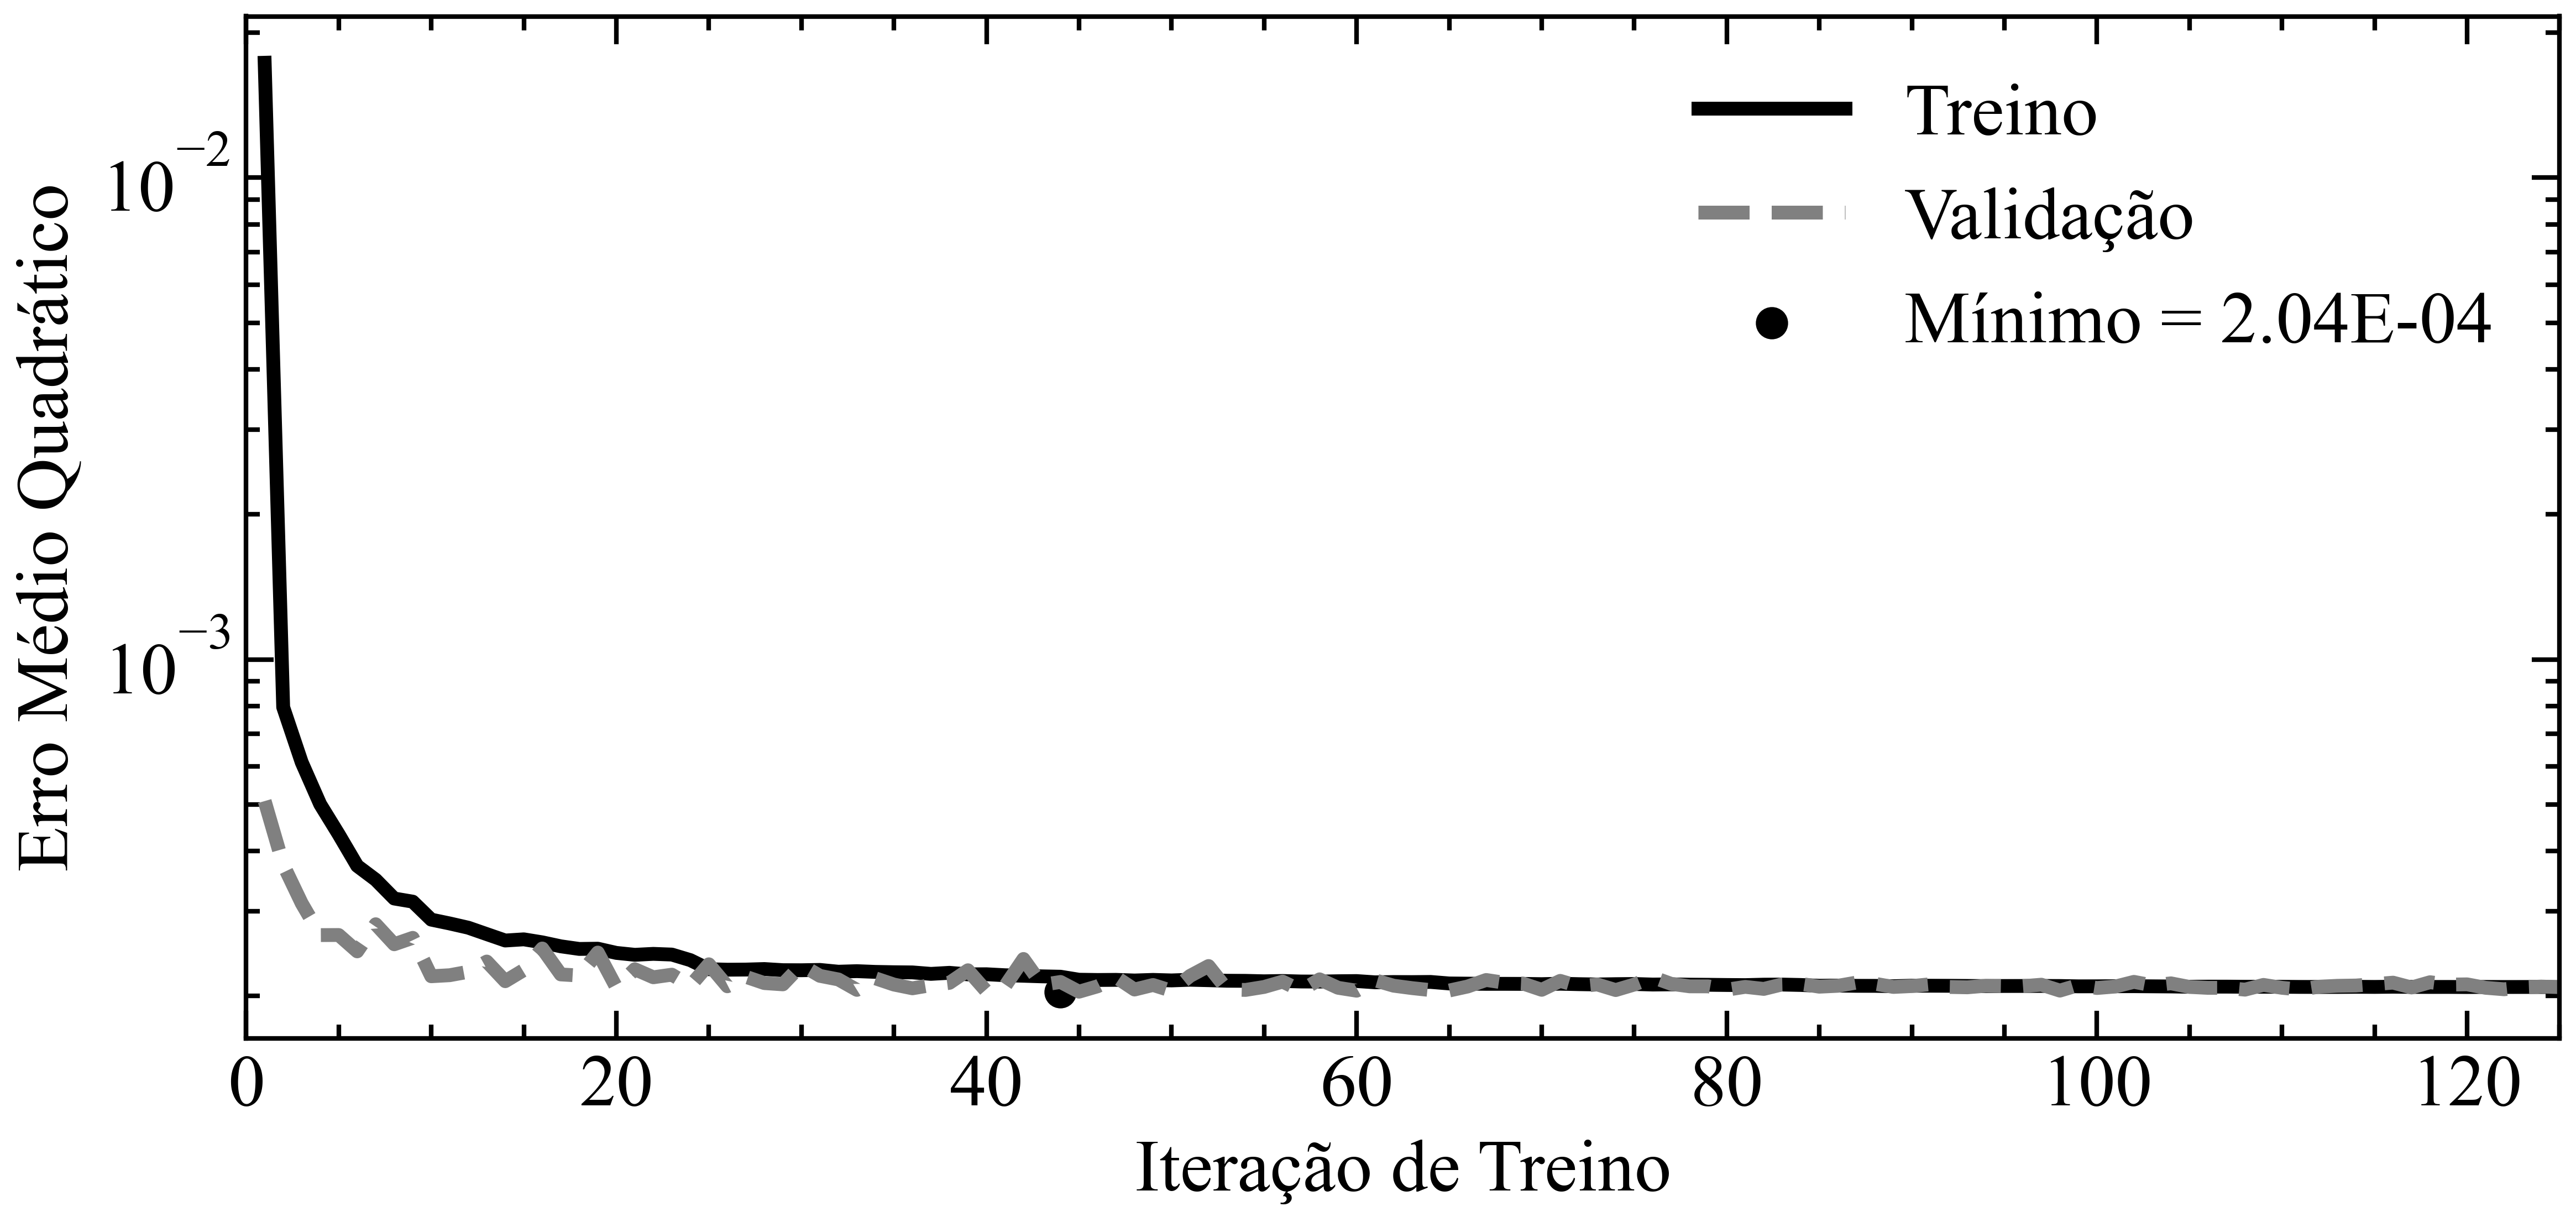

In [60]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = np.arange(1, len(loss) + 1)

plt.yscale("log", base=10)
plt.plot(epochs, loss, c="k", label="Treino", lw=3)
plt.plot(epochs, val_loss, c="grey", label="Validação", lw=3)
plt.scatter(
    np.argmin(val_loss), np.min(val_loss), label=f"Mínimo = {np.min(val_loss):.2E}"
)
plt.ylabel("Erro Médio Quadrático")
plt.xlabel("Iteração de Treino")
plt.xlim((0, len(loss)))
plt.legend()

plt.savefig("images/curva-de-aprendizdo.pdf", dpi=300, bbox_inches="tight")

In [61]:
run["model"].track_files("best_model.keras")

In [62]:
predictions = autoencoder.predict(Xtrain_N)

761/761 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step


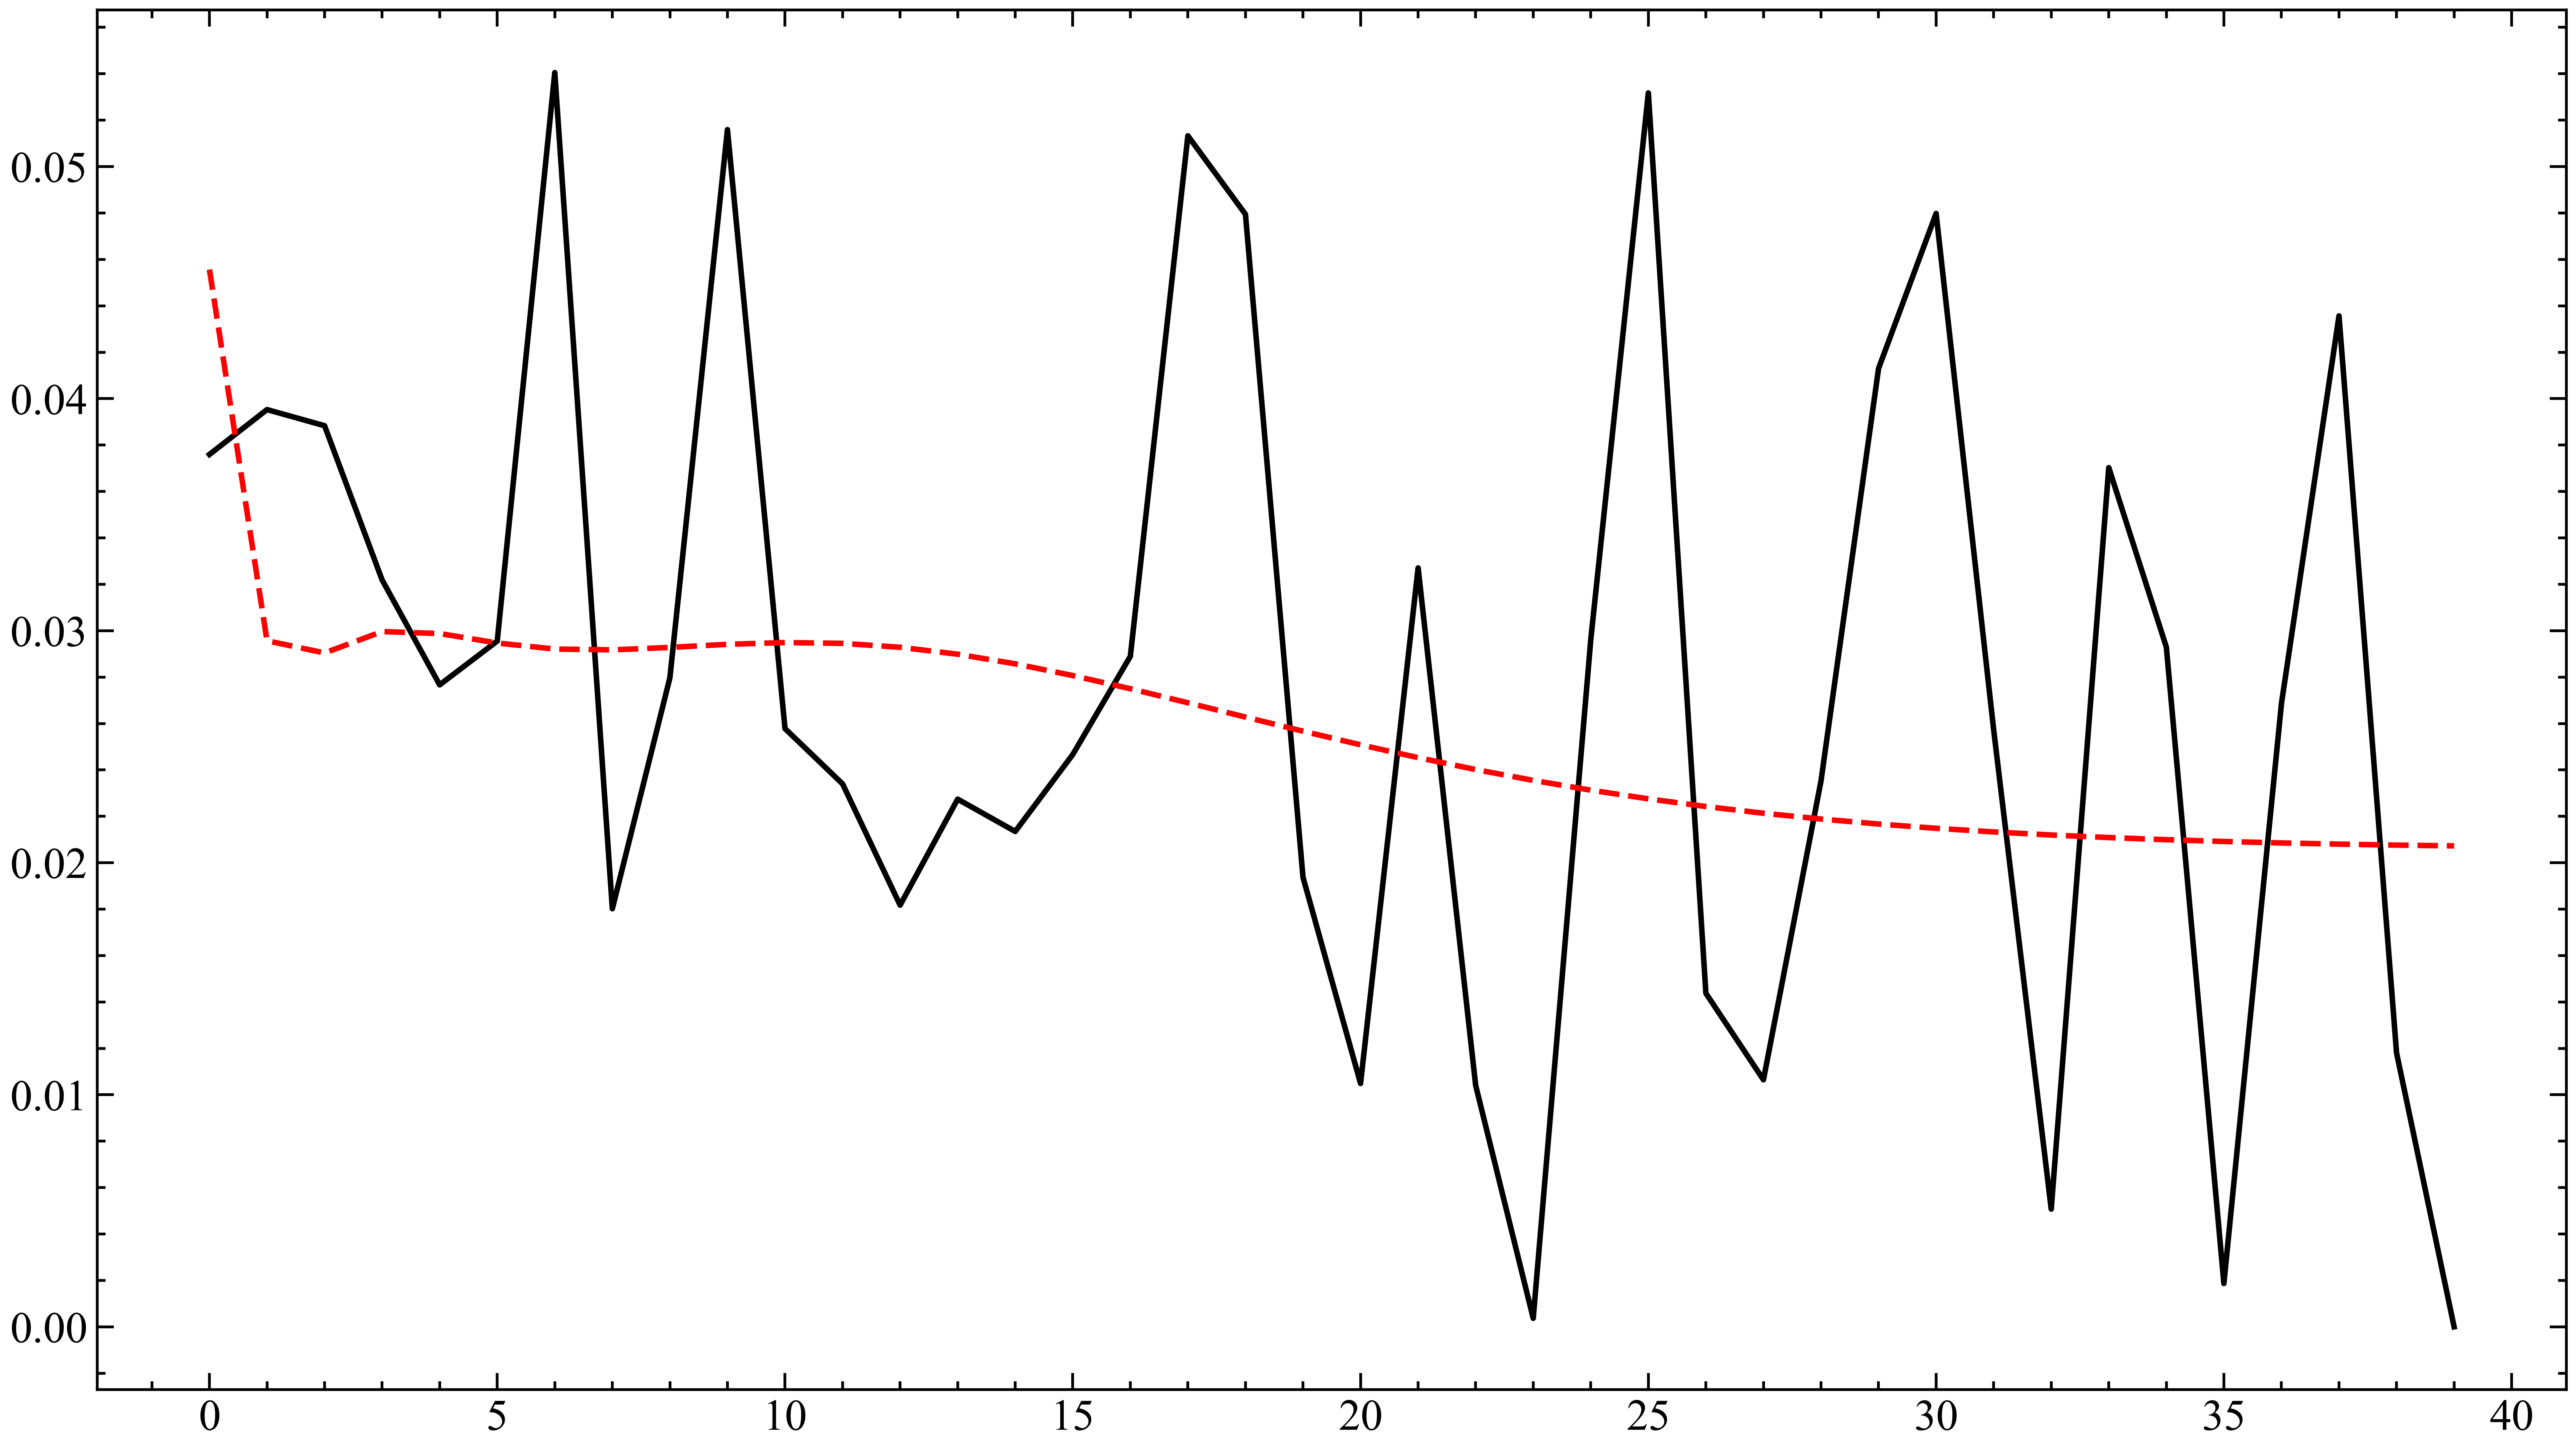

In [63]:
index: int = window_size * 100
plt.figure(figsize=(16, 9))
plt.plot(Xtrain_N[index])
plt.plot(predictions[index])

In [52]:
run.stop()

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] All 0 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/vinimelloemuller/TCC/e/TCC-3/metadata
